Considerações do trabalho:
- Apenas uma variável do dataset foi escolhida para geração sintética, a fim de evitar a complexidade de múltiplas variáveis dependentes.
- A variável escolhida é `platelets`, que representa a contagem de plaquetas no sangue. Esta foi selecionada por ser a variável mais independente e com maior quantidade de amostras disponíveis no dataset.
- Cada amostra será única, com um `timestamp` e `id` distintos do dataset original. Isto simplifica a geração de dados sintéticos, pois não há dependências temporais ou de grupo entre as amostras.
- A geração de dados sintéticos será feita utilizando uma distribuição normal, com média e desvio.
- É necessário gerar também os campos `age` e `gender`, estes valores condicionam a variável `platelets`. `age` e `gender` serão gerados na mesma proporção do dataset original, garantindo que a distribuição de idade e gênero seja mantida.
- Para validar o dataset sintético, serão realizadas análises estatísticas comparando as distribuições de `platelets`, `age` e `gender` entre o dataset original e o sintético. Serão utilizados as métricas de média, desvio padrão e histogramas para verificar a similaridade das distribuições.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

main_category_map = {
    "PLAQUETAS SANGUE": "platelets",
    "NEUTRÓFILOS ABSOLUTO": "neut_abs",
    "NEUTRÓFILOS %": "neut_pct",
    "NEUTRÓFILOS SEGMENTADOS %": "neut_segmented_pct",
    "LINFÓCITOS ABSOLUTO": "lym_abs",
    "LINFÓCITOS %": "lym_pct",
    "LINFOCITOS ATIPICOS TOTAL %": "lym_atypical_pct",
    "LEUCÓCITOS TOTAIS": "wbc_total",
    "EOSINÓFILOS ABSOLUTO": "eos_abs",
    "LUC ABSOLUTO": "luc_abs",
    "LUC %": "luc_pct",
    "PLASMÓCITOS ABSOLUTO": "pc_abs",
    "PLASMÓCITOS%": "pc_pct",
    "MCHC": "mchc",
    "OBSERVAÇÃO WBC": "obsservation_wbc",
    "OBSERVAÇÃO RBC": "observation_rbc",
    "OBSERVAÇÃO PLT": "observation_plt",
}

In [2]:
dataframes = []
for file in ['data1.csv', 'data2.csv', 'data3.csv']:
    df = pd.read_csv(file, header=None, 
                     names=['timestamp', 'age', 'id', 'sex', 'analyte', 'value'],
                     dtype={
                         'timestamp': 'str',
                         'age': 'int',
                         'id': 'str',
                         'sex': 'category',
                        'analyte': 'str',
                            'value': 'str'
                     })
    dataframes.append(df)
    
df = pd.concat(dataframes, ignore_index=True)

# switch the id column position with the age column
df = df[['timestamp', 'id', 'age', 'sex', 'analyte', 'value']]

# for the str camps to be strictly strings, we convert the 'value' column to string type
df['value'] = df['value'].astype(str)

df['value'] = df['value'].str.replace(',', '.', regex=False)

# remove rows that contain 'nan', or only spaces in the 'value' column
df = df[~df['value'].str.strip().isin(['nan', ''])]

# # convert 'value' column to float, coercing errors to NaN
df['value'] = pd.to_numeric(df['value'])

# remove rows where 'value' is NaN
df = df.dropna(subset=['value'])

df['analyte'] = df['analyte'].map(main_category_map).astype('category')

# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# sort by timestamp and id
df = df.sort_values(by=['timestamp', 'id']).reset_index(drop=True)

# filter for platelets only
df = df[df['analyte'] == 'platelets']

# remove rows where 'value' or 'analyte' is NaN
df = df.dropna(subset=['value', 'analyte'])

# keep a copy of the raw dataframe for reference
raw_df = df.copy()

# remove duplicates based on timestamp and id
df = df.drop_duplicates(subset=['timestamp', 'id'])

df


,timestamp,id,age,sex,analyte,value
0,2019-04-07 13:36:00,22536285,38,M,platelets,282.0
5,2019-10-12 12:53:00,25368842,7,M,platelets,268.0
10,2019-10-23 14:14:00,25354444,23,F,platelets,426.0
15,2019-10-23 23:08:00,18263638,24,M,platelets,263.0
20,2019-10-23 23:08:00,25384014,70,F,platelets,359.0
...,...,...,...,...,...,...
327201,2021-12-09 23:16:00,25369238,27,F,platelets,256.0
327206,2021-12-09 23:16:00,25963429,79,F,platelets,238.0
327211,2021-12-09 23:55:00,25981085,3,M,platelets,115.0
327216,2021-12-09 23:55:00,25981087,68,M,platelets,204.0


In [ ]:
# remove rows where the difference between consecutive timestamps is less than 1 hour
time_diff = df['timestamp'].diff().dt.total_seconds().fillna(0)
df = df[time_diff >= 3600]  # 3600

timestamp    0
id           0
age          0
sex          0
analyte      0
value        0
dtype: int64

count                            244
mean      43 days 09:14:37.377049180
std      130 days 11:27:00.064547800
min                  0 days 04:56:00
25%                  2 days 16:49:45
50%                  7 days 00:04:00
75%                 22 days 14:53:15
max                732 days 12:08:00
Name: time_diff, dtype: object


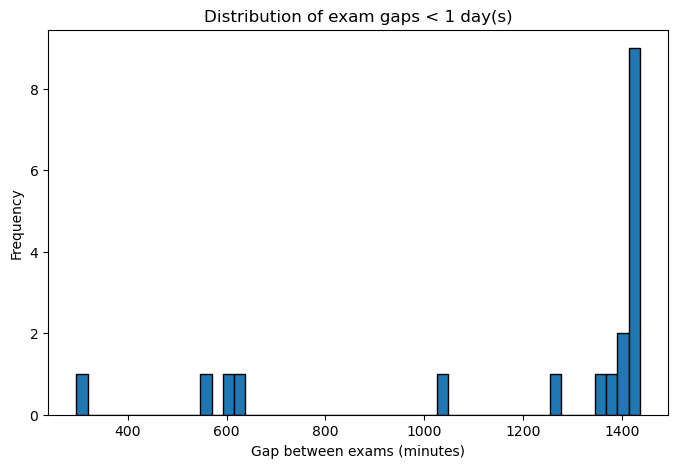

In [4]:
def assign_exam_groups(
    df: pd.DataFrame, time_threshold: pd.Timedelta | None = None
) -> pd.DataFrame:
    """
    Assigns exam group IDs for each patient.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta or None
        If None, groups by exact timestamp.
        If set, groups consecutive rows for the same patient
        when the gap is <= time_threshold.
    
    Returns
    -------
    pd.DataFrame
        Original DataFrame with 'exam_group' and 'global_exam_id' columns.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    if time_threshold is None:
        # Exact timestamp grouping
        df["exam_group"] = df.groupby(["id", "timestamp"], sort=False).ngroup()
    else:
        # Time threshold grouping
        df["new_exam"] = (
            df.groupby("id")["timestamp"]
            .diff()
            .gt(time_threshold)
            .fillna(True)
        )
        df["exam_group"] = df.groupby("id")["new_exam"].cumsum().astype(int)
        df = df.drop(columns="new_exam")

    # Create a global exam ID string
    df["global_exam_id"] = (
        df["id"].astype(str) + "_" + df["exam_group"].astype(str)
    )

    return df

def exam_time_gaps(df_grouped: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates time differences between consecutive exams for each patient
    from a DataFrame that already has 'exam_group'.
    """
    # Get the first timestamp of each exam
    exam_times = (
        df_grouped.groupby(["id", "exam_group"])["timestamp"]
        .min()
        .reset_index()
        .sort_values(["id", "timestamp"])
    )

    # Calculate time difference between consecutive exams
    exam_times["time_diff"] = exam_times.groupby("id")["timestamp"].diff()

    return exam_times


def plot_small_gaps(exam_times: pd.DataFrame, max_days: int = 1):
    """
    Plots histogram of time differences up to max_days.
    """
    small_gaps = exam_times["time_diff"].dropna()
    small_gaps = small_gaps[small_gaps < pd.Timedelta(days=max_days)]
    small_gaps_minutes = small_gaps.dt.total_seconds() / 60

    plt.figure(figsize=(8, 5))
    plt.hist(small_gaps_minutes, bins=50, edgecolor="black")
    plt.xlabel("Gap between exams (minutes)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of exam gaps < {max_days} day(s)")
    plt.show()

# 1. Group exams (exact timestamp)
df_grouped = assign_exam_groups(df, time_threshold=None)

# OR: Group exams with a 60-minute tolerance
# df_grouped = assign_exam_groups(df, time_threshold=pd.Timedelta("60min"))

# 2. Calculate time gaps
gaps_df = exam_time_gaps(df_grouped)

# 3. Inspect stats
print(gaps_df["time_diff"].describe())

# 4. Plot small gaps
plot_small_gaps(gaps_df, max_days=1)

In [17]:
print(len(df[df['value'] > 500]), len(df[df['value'] < 150]))
print(len(df[df['value'] > 500]) / len(df) * 100, "% of total exams")
print(len(df[df['value'] < 150]) / len(df) * 100, "% of total exams")
print("Total exams:", len(df))

66 418
3.290129611166501 % of total exams
20.837487537387837 % of total exams
Total exams: 2006


/tmp/ipykernel_145390/3126450617.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['value_no_outliers'] = np.exp(df_no_outliers['log_value'])
/tmp/ipykernel_145390/3126450617.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Raw', 'Processed', 'No Outliers'])


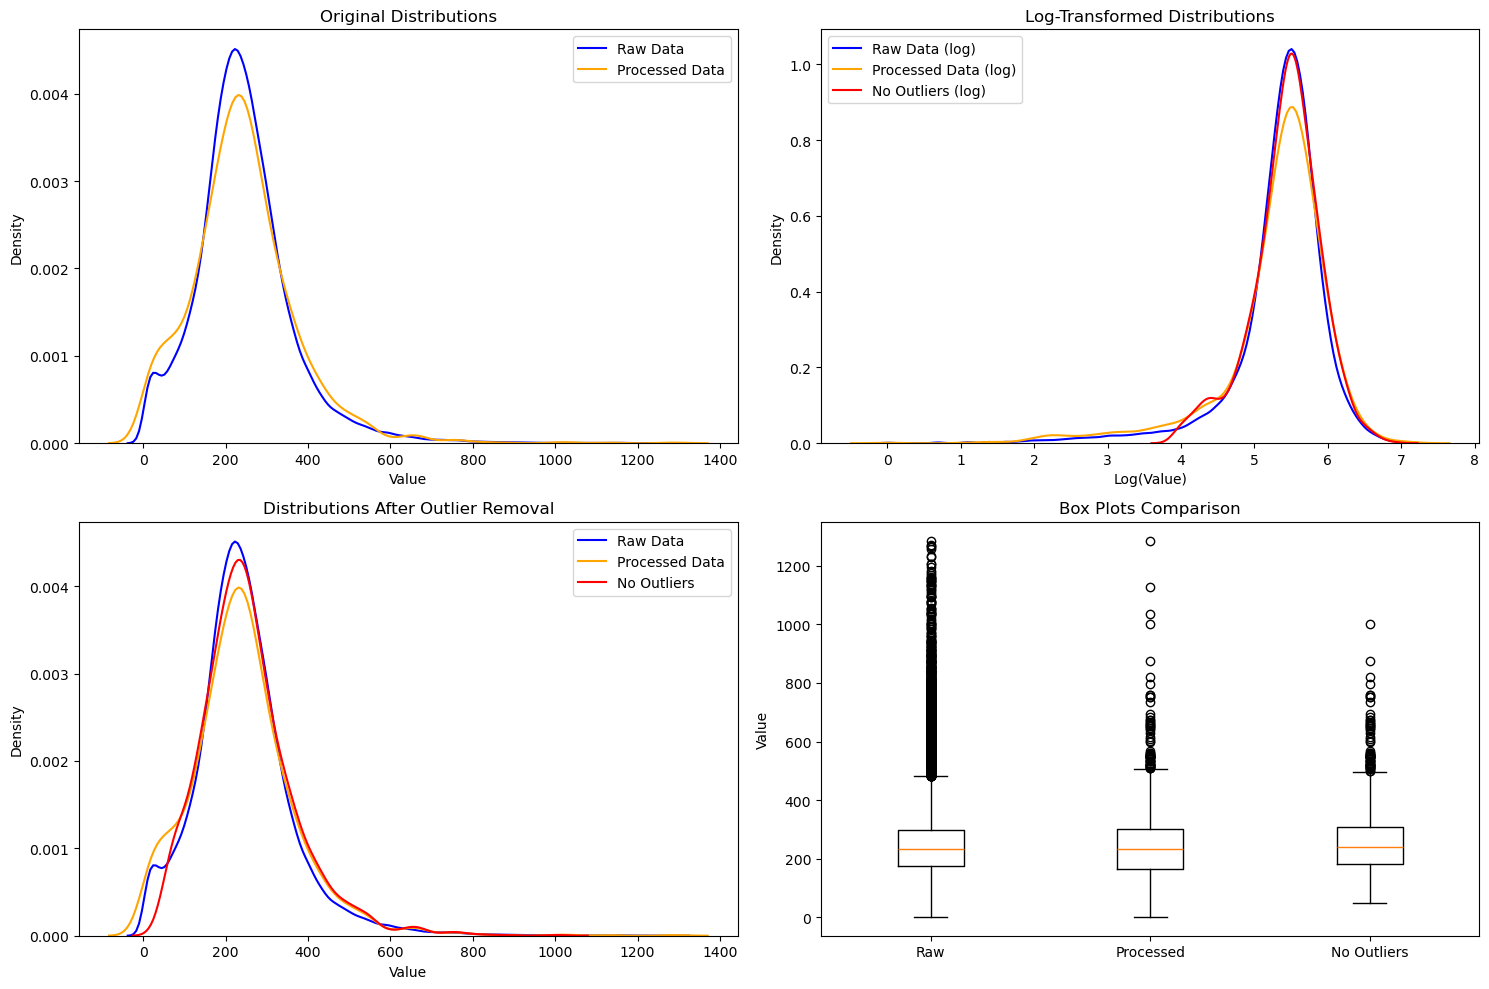

Raw Data (Filtered) Statistics:
count    64047.000000
mean       243.515441
std        118.927786
min          1.000000
25%        175.000000
50%        233.000000
75%        298.000000
max       1286.000000
Name: value, dtype: float64
Number of samples: 64047

Processed Data Statistics:
count    2006.000000
mean      241.610169
std       128.595969
min         1.000000
25%       165.000000
50%       233.000000
75%       302.000000
max      1286.000000
Name: value, dtype: float64
Number of samples: 2006

Data Without Outliers Statistics:
count    1885.000000
mean      253.764456
std       114.690230
min        50.000000
25%       181.000000
50%       239.000000
75%       308.000000
max      1003.000000
Name: value_no_outliers, dtype: float64
Number of samples: 1885
Outliers removed: 121 (6.0%)


In [8]:
raw_df_filtered = raw_df[raw_df['value'] <= 1286]   

# Apply log-normal transformation to remove outliers
# First, ensure all values are positive (add small constant if needed)
df_log = df.copy()
df_log['log_value'] = np.log(df_log['value'])

# Remove outliers using IQR method on log-transformed data
Q1 = df_log['log_value'].quantile(0.25)
Q3 = df_log['log_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Filter data within bounds
df_no_outliers = df_log[(df_log['log_value'] >= lower_bound) & (df_log['log_value'] <= upper_bound)]

# Transform back to original scale
df_no_outliers['value_no_outliers'] = np.exp(df_no_outliers['log_value'])

# Plot distributions comparison
plt.figure(figsize=(15, 10))

# Original distributions
plt.subplot(2, 2, 1)
sns.kdeplot(raw_df_filtered['value'], label='Raw Data', color='blue')
sns.kdeplot(df['value'], label='Processed Data', color='orange')
plt.title('Original Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Log-transformed distributions
plt.subplot(2, 2, 2)
sns.kdeplot(np.log(raw_df_filtered['value']), label='Raw Data (log)', color='blue')
sns.kdeplot(df_log['log_value'], label='Processed Data (log)', color='orange')
sns.kdeplot(df_no_outliers['log_value'], label='No Outliers (log)', color='red')
plt.title('Log-Transformed Distributions')
plt.xlabel('Log(Value)')
plt.ylabel('Density')
plt.legend()

# Back-transformed distribution without outliers
plt.subplot(2, 2, 3)
sns.kdeplot(raw_df_filtered['value'], label='Raw Data', color='blue')
sns.kdeplot(df['value'], label='Processed Data', color='orange')
sns.kdeplot(df_no_outliers['value_no_outliers'], label='No Outliers', color='red')
plt.title('Distributions After Outlier Removal')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Box plots for comparison
plt.subplot(2, 2, 4)
data_to_plot = [raw_df_filtered['value'], df['value'], df_no_outliers['value_no_outliers']]
plt.boxplot(data_to_plot, labels=['Raw', 'Processed', 'No Outliers'])
plt.title('Box Plots Comparison')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# Display summary statistics for all versions
print("Raw Data (Filtered) Statistics:")
print(raw_df_filtered['value'].describe())
print(f"Number of samples: {len(raw_df_filtered)}")

print("\nProcessed Data Statistics:")
print(df['value'].describe())
print(f"Number of samples: {len(df)}")

print("\nData Without Outliers Statistics:")
print(df_no_outliers['value_no_outliers'].describe())
print(f"Number of samples: {len(df_no_outliers)}")
print(f"Outliers removed: {len(df) - len(df_no_outliers)} ({100 * (len(df) - len(df_no_outliers)) / len(df):.1f}%)")

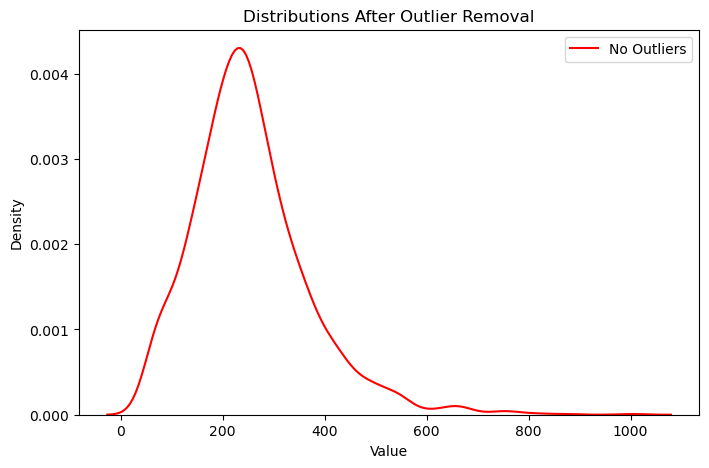

In [9]:
# Back-transformed distribution without outliers
plt.figure(figsize=(8, 5))
sns.kdeplot(df_no_outliers['value_no_outliers'], label='No Outliers', color='red')
plt.title('Distributions After Outlier Removal')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

In [17]:
# Undersample df_no_outliers so that each id only has maximum 2 samples
df_undersampled = df_no_outliers.groupby('id').head(3).reset_index(drop=True)

print(f"Original dataset size: {len(df_no_outliers)} samples")
print(f"Undersampled dataset size: {len(df_undersampled)} samples")
print(f"Number of unique patients: {df_undersampled['id'].nunique()}")

# Check the distribution of samples per patient
samples_per_patient = df_undersampled['id'].value_counts()
print(f"\nSamples per patient distribution:")
print(samples_per_patient.value_counts().sort_index())

# Display basic statistics
print(f"\nUndersampled dataset statistics:")
print(df_undersampled['value_no_outliers'].describe())

Original dataset size: 1748 samples
Undersampled dataset size: 1730 samples
Number of unique patients: 1604

Samples per patient distribution:
count
1    1490
2     102
3      12
Name: count, dtype: int64

Undersampled dataset statistics:
count    1730.000000
mean      256.777457
std        93.050554
min        91.000000
25%       191.000000
50%       245.000000
75%       308.000000
max       552.000000
Name: value_no_outliers, dtype: float64


Patients with single exam: 1490 (1490 records)
Patients with multiple exams: 112 (234 records)
Average exams per multi-exam patient: 2.09


/tmp/ipykernel_85869/826666461.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_to_plot, labels=['Single exam', 'Multiple exams'])


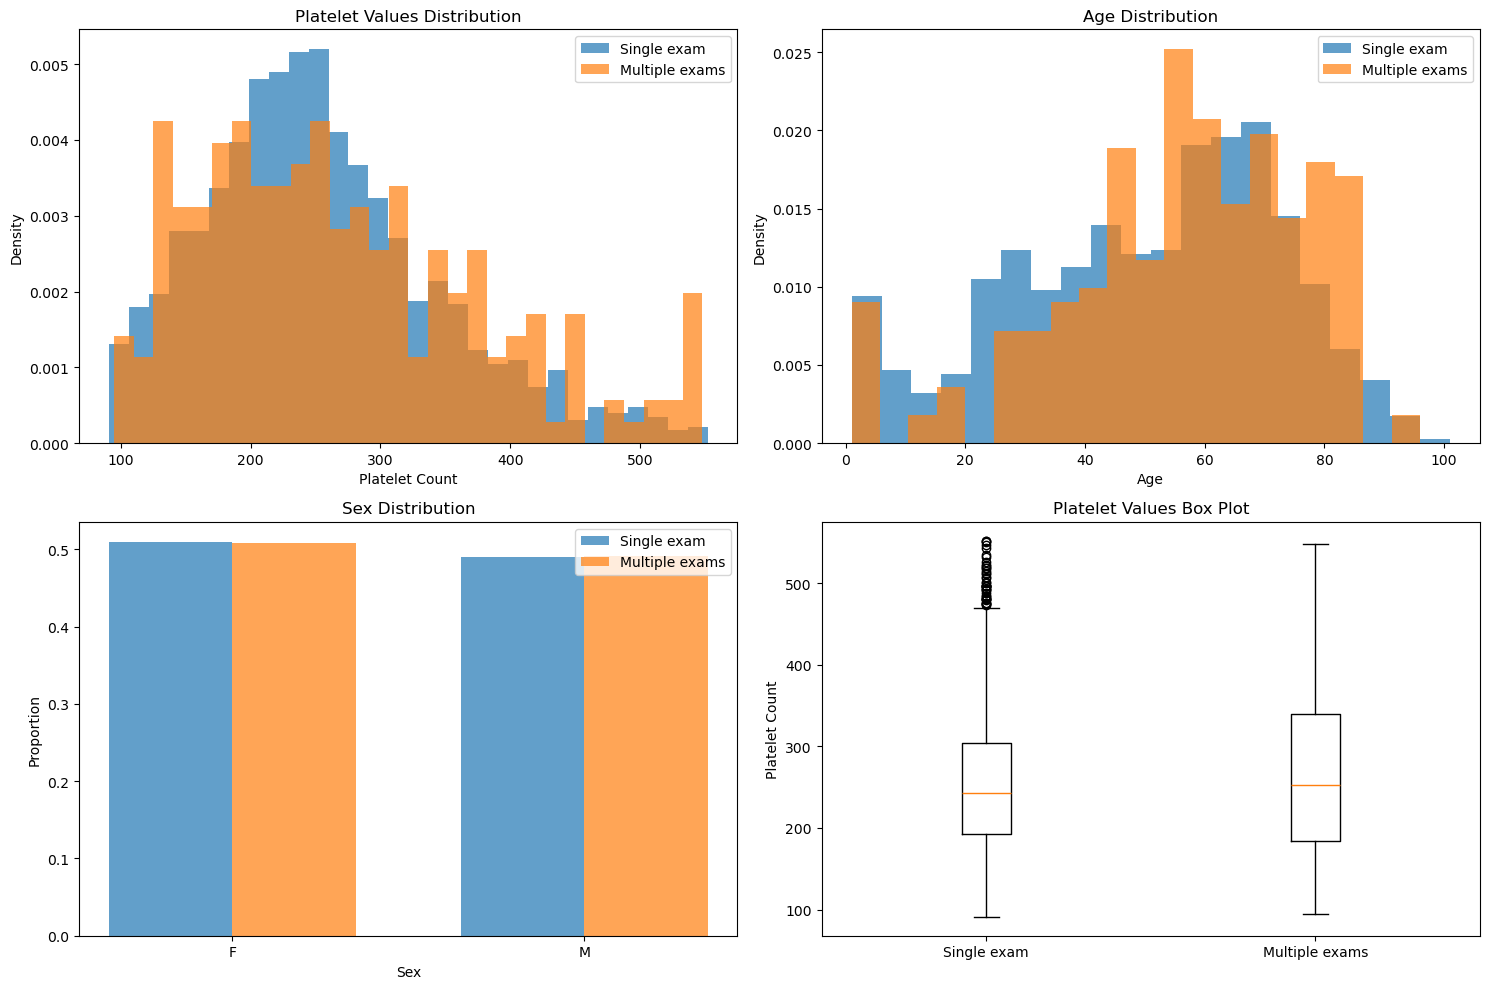


=== STATISTICAL COMPARISON ===

Platelet Values:
Single exam - Mean: 254.98, Std: 90.24
Multiple exams - Mean: 269.70, Std: 109.05

Age:
Single exam - Mean: 49.98, Std: 22.35
Multiple exams - Mean: 56.37, Std: 20.44

Sex distribution:
Single exam:
sex
F    0.510067
M    0.489933
Name: proportion, dtype: float64
Multiple exams:
sex
F    0.508547
M    0.491453
Name: proportion, dtype: float64

=== MULTIPLE EXAM PATIENTS BREAKDOWN ===
count
2     102
3      10
5       1
19      1
Name: count, dtype: int64


In [10]:
# Get exam counts per patient from df_no_outliers
exam_counts = df_no_outliers['id'].value_counts()

# Separate patients by exam frequency
single_exam_patients = exam_counts[exam_counts == 1].index
multiple_exam_patients = exam_counts[(exam_counts > 1) & (exam_counts < 5)].index

# Filter data for each group
single_exam_data = df_no_outliers[df_no_outliers['id'].isin(single_exam_patients)]
multiple_exam_data = df_no_outliers[df_no_outliers['id'].isin(multiple_exam_patients)]

print(f"Patients with single exam: {len(single_exam_patients)} ({len(single_exam_data)} records)")
print(f"Patients with multiple exams: {len(multiple_exam_patients)} ({len(multiple_exam_data)} records)")
print(f"Average exams per multi-exam patient: {len(multiple_exam_data) / len(multiple_exam_patients):.2f}")

# Compare distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Platelet value distributions
axes[0, 0].hist(single_exam_data['value_no_outliers'], bins=30, alpha=0.7, label='Single exam', density=True)
axes[0, 0].hist(multiple_exam_data['value_no_outliers'], bins=30, alpha=0.7, label='Multiple exams', density=True)
axes[0, 0].set_title('Platelet Values Distribution')
axes[0, 0].set_xlabel('Platelet Count')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Age distributions
axes[0, 1].hist(single_exam_data['age'], bins=20, alpha=0.7, label='Single exam', density=True)
axes[0, 1].hist(multiple_exam_data['age'], bins=20, alpha=0.7, label='Multiple exams', density=True)
axes[0, 1].set_title('Age Distribution')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Sex distribution
single_sex_counts = single_exam_data['sex'].value_counts(normalize=True)
multiple_sex_counts = multiple_exam_data['sex'].value_counts(normalize=True)
x = range(len(single_sex_counts))
width = 0.35
axes[1, 0].bar([i - width/2 for i in x], single_sex_counts.values, width, label='Single exam', alpha=0.7)
axes[1, 0].bar([i + width/2 for i in x], multiple_sex_counts.values, width, label='Multiple exams', alpha=0.7)
axes[1, 0].set_title('Sex Distribution')
axes[1, 0].set_xlabel('Sex')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(single_sex_counts.index)
axes[1, 0].legend()

# Box plots comparison
data_to_plot = [single_exam_data['value_no_outliers'], multiple_exam_data['value_no_outliers']]
axes[1, 1].boxplot(data_to_plot, labels=['Single exam', 'Multiple exams'])
axes[1, 1].set_title('Platelet Values Box Plot')
axes[1, 1].set_ylabel('Platelet Count')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n=== STATISTICAL COMPARISON ===")
print("\nPlatelet Values:")
print(f"Single exam - Mean: {single_exam_data['value_no_outliers'].mean():.2f}, Std: {single_exam_data['value_no_outliers'].std():.2f}")
print(f"Multiple exams - Mean: {multiple_exam_data['value_no_outliers'].mean():.2f}, Std: {multiple_exam_data['value_no_outliers'].std():.2f}")

print("\nAge:")
print(f"Single exam - Mean: {single_exam_data['age'].mean():.2f}, Std: {single_exam_data['age'].std():.2f}")
print(f"Multiple exams - Mean: {multiple_exam_data['age'].mean():.2f}, Std: {multiple_exam_data['age'].std():.2f}")

print("\nSex distribution:")
print("Single exam:")
print(single_sex_counts)
print("Multiple exams:")
print(multiple_sex_counts)

# Detailed breakdown of multiple exam patients
print(f"\n=== MULTIPLE EXAM PATIENTS BREAKDOWN ===")
print(exam_counts[exam_counts > 1].value_counts().sort_index())